# Tutorial: Deep Learning Application

https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.L042035

https://www.nature.com/articles/s41598-021-91878-w


## Import packages

In [14]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [15]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import matplotlib.pyplot as plt
import scipy as sci
import scipy.stats as stats

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# ConservNet

## Dataset Generation (Simple toy model)

\begin{equation} C = x_1 - 3x_2 x_3 - \frac{1}{2} x_4^2
\end{equation}

In [17]:
def simple_system(batch_size):
  Const = np.random.uniform(-1,1)
  x2 = np.random.randn(batch_size)
  x3 = np.random.randn(batch_size)
  x4 = np.random.randn(batch_size)
  x1 = Const + 3*x2*x3 + 0.5*x4**2
  return np.array([x1, x2, x3, x4]).T, np.array([Const for _ in range(batch_size)])

### Gathering train dataset - torch.dataloader

In [18]:
np.random.seed(42)
torch.manual_seed(42)

train_data = []
train_label = []
N = 10
M = 100
for i in tqdm(range(N)):
  data, label = simple_system(M)
  train_data.extend(data)
  train_label.extend(label) # meaningless

100%|██████████| 10/10 [00:00<00:00, 7934.74it/s]


In [19]:
train_dataset = TensorDataset(torch.FloatTensor(np.array(train_data)), torch.FloatTensor(np.array(train_label)))
train_loader = DataLoader(train_dataset, batch_size=N*M, shuffle=False)

## Define ConservNet

In [20]:
class ConservNet(nn.Module):
    def __init__(self):
        super(ConservNet, self).__init__()
        hidden_size = 160

        self.classifier = nn.Sequential(nn.Linear(4,hidden_size),
                                        nn.Mish(),
                                        nn.Linear(hidden_size,hidden_size),
                                        nn.Mish(),
                                        nn.Linear(hidden_size,hidden_size),
                                        nn.Mish(),
                                        nn.Linear(hidden_size,hidden_size),
                                        nn.Mish(),
                                        nn.Linear(hidden_size, 1, bias=False))
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
                if m.bias is not None:
                  m.bias.data.zero_()

    def forward(self, x):
        out = self.classifier(x)
        return out

### Define noiser for calculate Noise-Variance Loss

In [21]:
# DEFINE LOSS
def nv_loss(model, x, group_size, noise_std, Q):
    out = model(x)                      # (n_steps, 1)
    out = out.view(-1, group_size)   # (num_groups, group_size)
    var_orig = out.var(dim=1)

    noise = torch.randn_like(x) * noise_std
    out_noise = model(x + noise).view(-1, group_size)
    var_noise = out_noise.var(dim=1)

    loss = var_orig.mean() + (Q - var_noise).clamp(min=0).mean()
    return loss

## Train model

In [22]:
model = ConservNet()
model.train()
model.to(device)
model

ConservNet(
  (classifier): Sequential(
    (0): Linear(in_features=4, out_features=160, bias=True)
    (1): Mish()
    (2): Linear(in_features=160, out_features=160, bias=True)
    (3): Mish()
    (4): Linear(in_features=160, out_features=160, bias=True)
    (5): Mish()
    (6): Linear(in_features=160, out_features=160, bias=True)
    (7): Mish()
    (8): Linear(in_features=160, out_features=1, bias=False)
  )
)

In [23]:
## train
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-5, weight_decay=0)
best_loss = 1
epochs = 20000
count = 0
mean_loss = None
for epoch in range(epochs):
    epoch_loss = []
    for data, _ in train_loader:
        optimizer.zero_grad()

        data = data.to(device)
        train_loss = nv_loss(
            model,
            data,
            group_size=M,
            noise_std=1,
            Q=1
        )
        train_loss.backward()
        optimizer.step()

        epoch_loss.append(train_loss.item())

    mean_loss = np.sum(epoch_loss)/len(train_loader)
    if (epoch+1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {mean_loss:.4f}")
    
    if mean_loss < best_loss:
        best_loss = mean_loss
        best_model_state_dict = model.state_dict()
        count = 0
    else:
        count += 1 

    if count > 2000:
        print(f"Early stopping at epoch {epoch+1}")
        break

model.load_state_dict(best_model_state_dict)
model.eval()

Epoch 1000/20000, Loss: 0.0033
Epoch 2000/20000, Loss: 0.0010
Epoch 3000/20000, Loss: 0.0003
Epoch 4000/20000, Loss: 0.0001
Epoch 5000/20000, Loss: 0.0001
Epoch 6000/20000, Loss: 0.0000
Epoch 7000/20000, Loss: 0.0000
Epoch 8000/20000, Loss: 0.0000
Epoch 9000/20000, Loss: 0.0000
Epoch 10000/20000, Loss: 0.0000
Epoch 11000/20000, Loss: 0.0000
Epoch 12000/20000, Loss: 0.0000
Epoch 13000/20000, Loss: 0.0000
Epoch 14000/20000, Loss: 0.0000
Epoch 15000/20000, Loss: 0.0000
Epoch 16000/20000, Loss: 0.0000
Epoch 17000/20000, Loss: 0.0000
Epoch 18000/20000, Loss: 0.0000
Epoch 19000/20000, Loss: 0.0000
Early stopping at epoch 19350


ConservNet(
  (classifier): Sequential(
    (0): Linear(in_features=4, out_features=160, bias=True)
    (1): Mish()
    (2): Linear(in_features=160, out_features=160, bias=True)
    (3): Mish()
    (4): Linear(in_features=160, out_features=160, bias=True)
    (5): Mish()
    (6): Linear(in_features=160, out_features=160, bias=True)
    (7): Mish()
    (8): Linear(in_features=160, out_features=1, bias=False)
  )
)

## See the results

In [24]:
pred = []
c1 = []
model.eval()

with torch.no_grad():
  for data, label in train_loader:
    data = data.to(device)
    res = model(data)
    c1.extend(label.numpy())
    pred.extend(res.cpu().numpy())

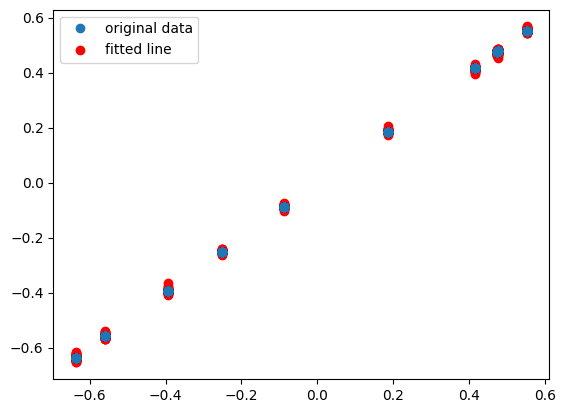

In [25]:
# linear regression true = pred * a +b
x = np.array(pred).flatten()
y = np.array(c1).flatten()
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y) # y = ax+b
plt.plot(y, y, 'o', label='original data')
plt.scatter(y, slope*x + intercept, label='fitted line', c="r")
plt.legend()
plt.show()

# AgentNet

## Dataset generation

In [27]:
def generate_vicsek_dataset(num_samples, num_agents, radius, vision_angle):
    inputs = []
    outputs = []
    for _ in range(num_samples):
        # random positions in unit square
        pos = np.random.rand(num_agents, 2)
        theta = np.random.rand(num_agents) * 2 * np.pi
        next_theta = np.zeros_like(theta)
        for i in range(num_agents):
            # relative positions
            rel = pos - pos[i]
            dist = np.linalg.norm(rel, axis=1)
            inside = (dist < radius) & (dist > 0)
            # neighbor directions
            angles = np.arctan2(rel[:, 1], rel[:, 0])
            diff = (angles - theta[i] + np.pi) % (2 * np.pi) - np.pi
            in_cone = np.abs(diff) < vision_angle / 2
            mask = inside & in_cone
            if mask.sum() > 0:
                avg = np.arctan2(np.mean(np.sin(theta[mask])), np.mean(np.cos(theta[mask])))
                next_theta[i] = avg
            else:
                next_theta[i] = theta[i]
        # state = (x, y, theta)
        inputs.append(np.concatenate([pos, theta[:, None]], axis=1))
        outputs.append(next_theta)
    return np.array(inputs), np.array(outputs)

# Dataset class

class VicsekDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

In [28]:
np.random.seed(42)
torch.manual_seed(42)

num_samples = 2000
N = 250
R = 0.3
phi_angle = np.pi / 2

X, y = generate_vicsek_dataset(num_samples, N, R, phi_angle)
dataset = VicsekDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [29]:
def plot_sample(X_sample, vision_radius, vision_angle, agent_idx=0):
    pos = X_sample[:, :2]
    theta = X_sample[:, 2]
    plt.figure(figsize=(6,6))
    # draw all agents as arrows
    plt.quiver(pos[:,0], pos[:,1], np.cos(theta), np.sin(theta),
               angles='xy', width=0.005)
    # highlight focal agent
    pi = pos[agent_idx]; ti = theta[agent_idx]
    plt.quiver([pi[0]], [pi[1]], [np.cos(ti)], [np.sin(ti)],
               angles='xy', width=0.008, color='red')
    # draw vision cone of focal agent
    angles = np.linspace(ti - vision_angle/2, ti + vision_angle/2, 50)
    xs = pi[0] + vision_radius * np.cos(angles)
    ys = pi[1] + vision_radius * np.sin(angles)
    plt.plot([pi[0]]+xs.tolist()+[pi[0]], [pi[1]]+ys.tolist()+[pi[1]], 'r--')
    plt.title('Vicsek sample with arrows & vision cone')
    plt.axis('equal')
    plt.show()

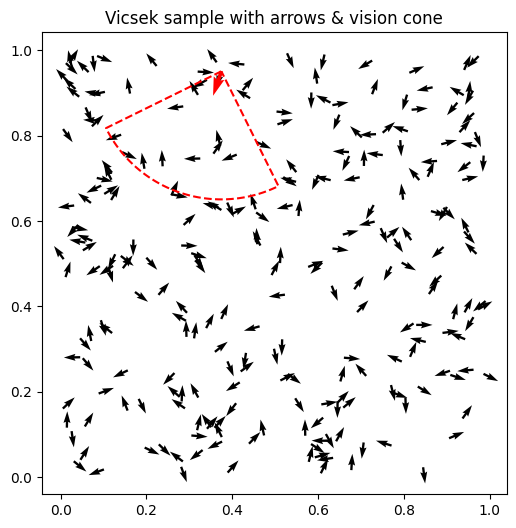

In [30]:
plot_sample(X[0], R, phi_angle, agent_idx=0)

## Define model

In [31]:
class AgentNet(nn.Module):
    # Not same as the one in the paper
    def __init__(self, input_dim=3, hidden_dim=64):
        super().__init__()
        self.phi = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU())
        self.q = nn.Linear(hidden_dim, hidden_dim)
        self.k = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, hidden_dim)
        self.pred = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        # x: (B, N, 3)
        B, N, _ = x.shape
        h = self.phi(x)             # (B, N, H)
        Q = self.q(h); K = self.k(h); V = self.v(h)
        # currently we do not use additional linear model, but simply using matrix multiplication
        scores = torch.matmul(Q, K.transpose(1, 2)) / (h.shape[-1]**0.5) # (B, N, N)
        A = torch.softmax(scores, dim=-1) # (B, N, N)
        ###########################
        # GET FINAL OUTPUT
        C = torch.matmul(A, V)  # (B, N, H)
        h_cat = torch.cat([h, C], dim=-1)
        out = self.pred(h_cat)
        out = torch.squeeze(out, dim=-1)
        ###########################
        return out, A


## Model Training

In [32]:
lr = 1e-3
epochs = 2000

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
model = AgentNet(input_dim=3, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_fn = nn.MSELoss()
model.train()
pbar = tqdm(range(epochs))
for ep in pbar:
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        pred, _ = model(X_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    pbar.set_description(f"Epoch {ep+1}/{epochs}")
    pbar.set_postfix(loss=f"{total_loss/len(dataloader):.4f}")
    
    # if (ep+1) % 40 == 0:
    #     print(f"Epoch {ep+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 2000/2000: 100%|██████████| 2000/2000 [07:23<00:00,  4.51it/s, loss=1.8453]


## Evaluation

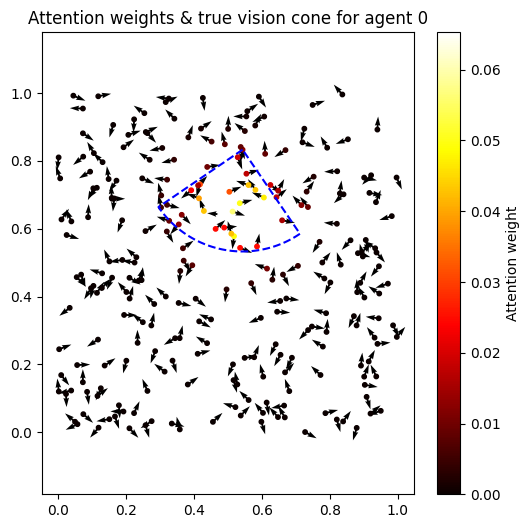

In [39]:
model.eval()
idx = 10
with torch.no_grad():
    sample_X = torch.tensor(X[idx:idx + 1], dtype=torch.float32).to(device)
    pred_theta, attention = model(sample_X)
attn = attention[0].cpu().numpy()  # (N, N)

# Final attention plot
plt.figure(figsize=(6,6))
# arrows colored by attention to focal agent
weights = attn[0]  # weights from focal agent 0 to all
pos = X[idx,:, :2]
theta = X[idx,:, 2]
plt.quiver(pos[:,0], pos[:,1], np.cos(theta), np.sin(theta),
            angles='xy', width=0.005,
            cmap='hot',)
plt.scatter(pos[:,0], pos[:,1], c=weights, cmap='hot', s=10)
plt.colorbar(label='Attention weight')
# draw focal vision cone
pi, ti = pos[0], theta[0]
angles = np.linspace(ti - phi_angle/2, ti + phi_angle/2, 50)
xs = pi[0] + R * np.cos(angles)
ys = pi[1] + R * np.sin(angles)
plt.plot([pi[0]]+xs.tolist()+[pi[0]], [pi[1]]+ys.tolist()+[pi[1]], 'b--')
plt.title('Attention weights & true vision cone for agent 0')
plt.axis('equal')
plt.show()
